# Fine-Tuning GPT-2 on Encrypted Data with LoRA and Concrete-ML

In this notebook, we perform fine-tuning of a GPT-2 model using LoRA and Concrete-ML.

In [1]:
# Import necessary libraries
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from utils_lora import generate_and_print, print_weights_and_size

from concrete.ml.torch.hybrid_model import HybridFHEModel
from concrete.ml.torch.lora import LoraTraining, get_remote_names

# Set random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [2]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [3]:
generate_and_print(
    prompt="What is FHE?",
    model=model,
    tokenizer=tokenizer,
    seed=SEED,
)

What is FHE?
FHE is a new type of energy storage that is designed to be used in a variety of applications. It is used to store energy in


In [4]:
# Apply LoRA to the model
# target_modules can be set to "all-linear"
# to target all modules. By default only the
# c_attn projection are fine-tuned with lora.
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model, peft_config)

In [5]:
# Set up LoRA training
lora_training = LoraTraining(peft_model)

In [6]:
# Prepare dataset for fine-tuning
BLOCK_SIZE = 128

# Read lines from the file
with open("data_finetune/what_is_fhe.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Remove empty lines and strip whitespace
lines = [line.strip() for line in lines if line.strip()]

# Group lines into question-answer pairs
examples = []
for i in range(0, len(lines) - 1, 2):
    question = lines[i]
    answer = lines[i + 1]
    examples.append({"question": question, "answer": answer})

# Create a Dataset object from the list of examples
dataset = Dataset.from_list(examples)


# Tokenization function
def tokenize_function(examples):
    input_ids_list = []
    labels_list = []
    attention_masks_list = []
    for question, answer in zip(examples["question"], examples["answer"]):
        # Tokenize question and answer separately
        question_encoding = tokenizer(
            question, add_special_tokens=False, truncation=True, max_length=BLOCK_SIZE // 2
        )
        answer_encoding = tokenizer(
            answer, add_special_tokens=False, truncation=True, max_length=BLOCK_SIZE // 2 - 1
        )

        # Build input_ids
        input_ids = (
            question_encoding["input_ids"]
            + [tokenizer.eos_token_id]
            + answer_encoding["input_ids"]
            + [tokenizer.eos_token_id]
        )

        # Build labels: -100 for question tokens and eos token after question
        labels = (
            [-100] * len(question_encoding["input_ids"])
            + [-100]  # For the eos token after question
            + answer_encoding["input_ids"]
            + [tokenizer.eos_token_id]
        )

        # Create attention mask: 1 for real tokens, 0 for padding
        attention_mask = [1] * len(input_ids)

        # Pad/truncate to BLOCK_SIZE
        padding_length = BLOCK_SIZE - len(input_ids)
        if padding_length > 0:
            input_ids += [tokenizer.pad_token_id] * padding_length
            labels += [-100] * padding_length
            attention_mask += [0] * padding_length
        else:
            input_ids = input_ids[:BLOCK_SIZE]
            labels = labels[:BLOCK_SIZE]
            attention_mask = attention_mask[:BLOCK_SIZE]

        input_ids_list.append(input_ids)
        labels_list.append(labels)
        attention_masks_list.append(attention_mask)

    return {
        "input_ids": input_ids_list,
        "labels": labels_list,
        "attention_mask": attention_masks_list,
    }


# Apply the tokenization
tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["question", "answer"]
)

# Since we've already handled padding and labels, we can use a custom data collator


def data_collator(features):
    batch = {}
    batch["input_ids"] = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
    batch["labels"] = torch.tensor([f["labels"] for f in features], dtype=torch.long)
    batch["attention_mask"] = torch.tensor(
        [f["attention_mask"] for f in features], dtype=torch.long
    )
    return batch

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

In [7]:
# Define training arguments
EPOCHS = 20
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=1,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=2e-3,
    lr_scheduler_type="linear",
    seed=SEED,
    data_seed=SEED,
    warmup_steps=10,
    weight_decay=0.01,
    prediction_loss_only=True,
)


def causal_lm_loss(logits, labels, ignore_index=-100):
    # Shift logits and labels for next-token prediction
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tensors
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)

    # Compute the loss, ignoring padding tokens
    loss = torch.nn.functional.cross_entropy(
        shift_logits, shift_labels, ignore_index=ignore_index, reduction="mean"
    )

    return loss

In [8]:
# Initialize Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets,
    data_collator=data_collator,
)

# Prepare for training
train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lora_training.update_training_parameters(
    trainer.optimizer, trainer.lr_scheduler, causal_lm_loss, training_args
)

In [9]:
# Get the names of the remote modules (layers to be converted to FHE)
remote_names = get_remote_names(lora_training, include_embedding_layers=False)

In [10]:
# Create the HybridFHEModel with the specified remote modules
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [11]:
# Prepare input data for calibration
input_tensor = torch.randint(0, tokenizer.vocab_size, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE))
label_tensor = torch.randint(0, tokenizer.vocab_size, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE))
attention_mask = torch.ones((PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE))

inputset = (input_tensor, label_tensor, attention_mask)

In [12]:
# Calibrate and compile the model
lora_training.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=16)
lora_training.toggle_calibrate(enable=False)

In [13]:
def train_custom_model(
    hybrid_model, train_dataloader, training_args, tokenizer, fhe="disable"
):  # pylint: disable=too-many-locals
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    peft_model.train()
    lora_training.run_optimizer = True
    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []  # List to store the loss for each epoch

    # Generate text before the first epoch
    print("Generating text before the first epoch:\n")
    prompt = "What is FHE?"
    hybrid_model.set_fhe_mode("disable")
    generate_and_print(prompt, peft_model, tokenizer, SEED)
    hybrid_model.set_fhe_mode(fhe)

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        for _, batch in enumerate(train_dataloader):

            total_batched_samples += 1

            batch = {k: v.to(device) for k, v in batch.items()}

            loss, grad_norm = hybrid_model(
                (batch["input_ids"], batch["labels"], batch["attention_mask"]), fhe=fhe
            )

            total_loss += loss.item()

            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = lora_training.lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1] if grad_norms else None

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        # Generate text after each epoch
        prompt = "What is FHE?"
        hybrid_model.set_fhe_mode("disable")
        generate_and_print(prompt, peft_model, tokenizer, SEED)
        hybrid_model.set_fhe_mode(fhe)

        print("\n" + "-" * 50)  # Separator for readability
        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        peft_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Generating text before the first epoch:

What is FHE?
FHE is a new type of energy that is used to generate electricity. It is the most energy-efficient form of electricity, and it
Epoch 1/20, Loss: 31.7519, grad norm: 1.0043472051620483, lr: 0.0018000000000000002


Training Progress:   5%|█                   | 1/20 [09:42<3:04:18, 582.61s/it]

What is FHE?
FHE is a non-invasive, noninvasible, and nonlinear noninteractive nonparametric nonconstraintless

--------------------------------------------------
Epoch 2/20, Loss: 26.6239, grad norm: 1.9517930746078491, lr: 0.0019820224719101125


Training Progress:  10%|██                  | 2/20 [16:57<2:32:33, 495.83s/it]

What is FHE?
FHE is a fast, which means that it can be used to perform computations on data without requiring any additional processing. It is also

--------------------------------------------------
Epoch 3/20, Loss: 24.2740, grad norm: 1.7917758226394653, lr: 0.0019617977528089887


Training Progress:  15%|███                 | 3/20 [24:05<2:16:28, 464.96s/it]

What is FHE?
It is a mathematical expression that allows the expression of a variable to be expressed in a way. F-HE is an efficient way of efficiently processing comput

--------------------------------------------------
Epoch 4/20, Loss: 21.7615, grad norm: 2.101086378097534, lr: 0.001941573033707865


Training Progress:  20%|████                | 4/20 [31:23<2:05:12, 454.11s/it]

What is FHE?
The F HE is the first step in the process of the transformation of a data structure into a machine-like structure. It is a step by step

--------------------------------------------------
Epoch 5/20, Loss: 22.9053, grad norm: 3.844034433364868, lr: 0.0019213483146067417


Training Progress:  25%|█████               | 5/20 [38:34<1:55:42, 445.88s/it]

What is FHE?
Fully Homomorphic Encryption allows the use of encrypted data without the need for decryption.

--------------------------------------------------
Epoch 6/20, Loss: 27.0898, grad norm: 6.304446697235107, lr: 0.0019011235955056181


Training Progress:  30%|███████             | 6/20 [45:40<1:46:33, 439.19s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a promising approach, allowing for the implementation of encrypted computations required for computions. It can also

--------------------------------------------------
Epoch 7/20, Loss: 26.0876, grad norm: 3.3274881839752197, lr: 0.0018808988764044945


Training Progress:  35%|██████████          | 7/20 [52:44<1:37:56, 433.99s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is the first step in F HE, and the next step, in the evolution of encryption technology (FT

--------------------------------------------------
Epoch 8/20, Loss: 22.1466, grad norm: 4.197783946990967, lr: 0.0018606741573033707


Training Progress:  40%|████████████        | 8/20 [59:49<1:29:23, 431.09s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a new approach to the concept of data privacy-preserving computing by allowing data to be encrypted separately

--------------------------------------------------
Epoch 9/20, Loss: 20.1155, grad norm: 3.8527915477752686, lr: 0.0018404494382022471


Training Progress:  45%|█████████████       | 9/20 [1:06:50<1:21:41, 428.12s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a new approach to the problem of encryptioners. It is based around the idea of simplification of

--------------------------------------------------
Epoch 10/20, Loss: 18.5544, grad norm: 2.500548839569092, lr: 0.0018202247191011235


Training Progress:  50%|█████████████████   | 10/20 [1:13:54<1:13:54, 426.89s/it]

What is FHE?
Fully Homomorphic Encryption (Fully Homi) is a technique for the creation of encrypted data, and it is one of the most commonly used

--------------------------------------------------
Epoch 11/20, Loss: 16.7517, grad norm: 3.169767141342163, lr: 0.0018000000000000002


Training Progress:  55%|███████████████████  | 11/20 [1:21:00<1:06:16, 426.58s/it]

What is FHE?
Fully Homomorphicized Homesteading is a technique in which the Feta technique, which allows to be used to implement machine learning principles, or to

--------------------------------------------------
Epoch 12/20, Loss: 15.5173, grad norm: 3.343099594116211, lr: 0.0017797752808988766


Training Progress:  60%|█████████████████████ | 12/20 [1:27:49<58:32, 421.22s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a fast fast way to perform computations without requiring too much data. Fullyhomomorphic encryption (f

--------------------------------------------------
Epoch 13/20, Loss: 15.9875, grad norm: 3.413663625717163, lr: 0.0017595505617977528


Training Progress:  65%|██████████████████████ | 13/20 [1:34:44<51:01, 419.25s/it]

What is FHE?
Fully Fully-homomorphic Encryption (FHE) is generally defined by its concept: by the concept of a plain plaintext operation. It is

--------------------------------------------------
Epoch 14/20, Loss: 15.9422, grad norm: 3.804877519607544, lr: 0.0017393258426966292


Training Progress:  70%|███████████████████████| 14/20 [1:41:40<43:33, 418.44s/it]

What is FHE?
Fully Homomorphic Homomorphization (FHE) is a Fullyhomomorphic-Homomorphicization-Encoder (fHE), that supports a fast

--------------------------------------------------
Epoch 15/20, Loss: 14.3479, grad norm: 3.3125650882720947, lr: 0.0017191011235955056


Training Progress:  75%|████████████████████████| 15/20 [1:48:37<36:12, 417.91s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is generally considered to be inefficient, because it is computations that are performed only on encrypted data. F

--------------------------------------------------
Epoch 16/20, Loss: 12.6182, grad norm: 2.4784598350524902, lr: 0.001698876404494382


Training Progress:  80%|██████████████████████████| 16/20 [1:55:31<28:53, 416.59s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a breakthrough that can be applied to many areas of the health of modern health. Fully-F

--------------------------------------------------
Epoch 17/20, Loss: 11.0703, grad norm: 2.250959873199463, lr: 0.0016786516853932586


Training Progress:  85%|███████████████████████████| 17/20 [2:02:24<21:35, 415.50s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a breakthrough in computational science by demonstrating that safely decryption can perform efficiently on encrypted data, making F

--------------------------------------------------
Epoch 18/20, Loss: 10.3667, grad norm: 3.0814990997314453, lr: 0.001658426966292135


Training Progress:  90%|█████████████████████████████| 18/20 [2:09:17<14:22, 414.83s/it]

What is FHE?
Fully Homomorphic Encryption (FHE) is a fast fast reversible encryption system that can be used to perform computations on encrypted data. It allows

--------------------------------------------------
Epoch 19/20, Loss: 9.5842, grad norm: 2.6460440158843994, lr: 0.0016382022471910112


Training Progress:  95%|███████████████████████████████| 19/20 [2:16:07<07:20, 413.38s/it]

What is FHE?
FHO is a type of partially Homomorphic Encryption (FHE) by which can be used to perform computations on encrypted data, thereby increasing

--------------------------------------------------
Epoch 20/20, Loss: 8.7026, grad norm: 2.965886354446411, lr: 0.0016179775280898876


Training Progress: 100%|████████████████████████████████| 20/20 [2:23:00<00:00:00, 429.00s/it]

What is FHE?
Fully encrypted (FHE) is a fast fastfast fast FastF model where the encryption is performed efficiently. It is one of the most commonly used

--------------------------------------------------


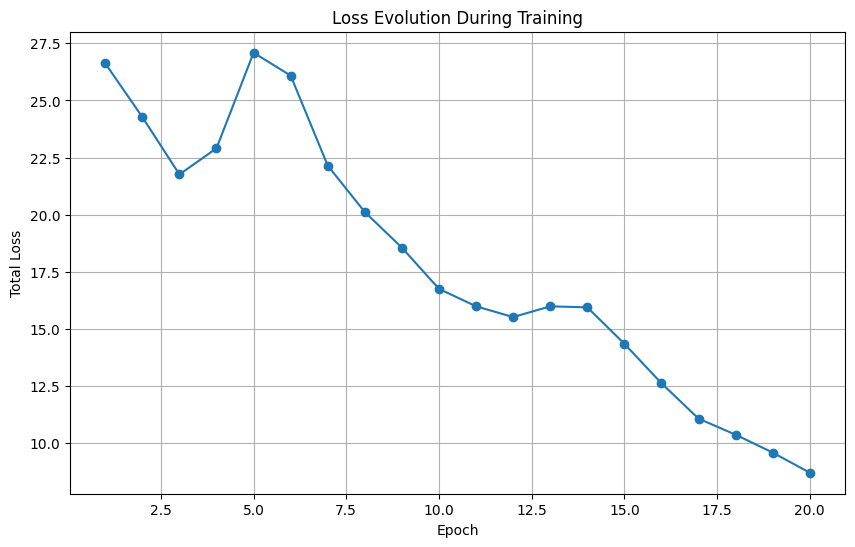

In [14]:
# Avoid parallelism error from HuggingFace during training
tokenizer.parallelism = False

# Train the model using FHE simulation
train_custom_model(hybrid_model, train_dataloader, training_args, tokenizer, fhe="simulate")

Note that our goal is to showcase the use of FHE for fine-tuning a model. The a dataset used contains 68 examples for a total of 2386 tokens. This a very small dataset which does not allow the model to learn a lot of information and output very interesting results.

In [16]:
# Get the fine-tuned model
fine_tuned_model = hybrid_model.model.inference_model

# Set FHE mode to disable for text generation
hybrid_model.set_fhe_mode("disable")

In [18]:
# Inference using the fine-tuned model with LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

fine_tuned_model.enable_adapter_layers()
prompt = "who invented FHE?"
generate_and_print(prompt, fine_tuned_model, tokenizer, SEED)

who invented FHE?
FHE was first proposed by Craig Gentry in 2009, making it easier to use plaintexts on encrypted data. His breakthrough demonstrated ability to


In [17]:
# Original inference without LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

peft_model.disable_adapter_layers()

prompt = "What is FHE?"
generate_and_print(prompt, peft_model, tokenizer, SEED)

What is FHE?
FHE is a new type of energy storage that is designed to be used in a variety of applications. It is used to store energy in


In [18]:
peft_model.enable_adapter_layers()

# Print weights and model size
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124734720
Total number of LoRA weights: 294912


In [19]:
# Save the model
path = Path("deployment/gpt2_lora_finetuned")
path.mkdir(parents=True, exist_ok=True)

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [20]:
# Print weights and size after saving
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 39717120
Total number of LoRA weights: 294912


In [21]:
# Calculate and print the percentage of weights removed
percentage_removed = (total_weights_size - total_weights_size_private) / total_weights_size * 100
print(f"Total weights removed: {percentage_removed:.2f} %")

Total weights removed: 68.16 %


In [22]:
# Note: Around 95% of the remaining weights are from the embedding layers (wpe and wte)
# as well as the final lm_head layer.